In [1]:
%load_ext autoreload
%autoreload 2

from helpers import *

from IPython.display import clear_output

import bz2
import json

import pandas as pd

import numpy as np

from pprint import *

from perform_general_analysis import *

import matplotlib.pyplot as plt

## Raw Data Exploration

We compute some simple stats on the raw dataset(s). Since, they are so large
they need to be loaded in chunks and various starts are aggregated after 
each chunk's computation. This should give a better understand of the
data we are working with. More about this below.

Lets start with calculating some statistics for all the quote banks dataset from 2015 to 2020

In [6]:
all_paths = [QUOTES_2015_PATH,QUOTES_2016_PATH,QUOTES_2017_PATH,QUOTES_2017_PATH,QUOTES_2019_PATH,QUOTES_2020_PATH]
all_stats = []
for path in all_paths:
    stat_per_year,_ = build_stat_dics(path)
    all_stats.append(stat_per_year)

#Chunks=3
{'year': 'null', 'count': 300000, 'count_no_speaker': 103282, 'quotation': {'chars': {'min_length': 9, 'max_length': 2918, 'sum_length': 41205538, 'length_bins': array([0., 0., 0., ..., 0., 0., 0.]), 'avg_length': 137.35}, 'words': {'min_length': 1, 'max_length': 459, 'sum_length': 7411753, 'length_bins': array([ 0.,  2., 18., ...,  0.,  0.,  0.]), 'avg_length': 24.71}}}
{'count': 300000,
 'count_no_speaker': 103282,
 'quotation': {'chars': {'avg_length': 137.35,
                         'length_bins': array([0., 0., 0., ..., 0., 0., 0.]),
                         'max_length': 2918,
                         'min_length': 9,
                         'sum_length': 41205538},
               'words': {'avg_length': 24.71,
                         'length_bins': array([ 0.,  2., 18., ...,  0.,  0.,  0.]),
                         'max_length': 459,
                         'min_length': 1,
                         'sum_length': 7411753}},
 'year': 'null'}
data.nosync/quotebank/qu

Now, aggregate all to get a full statistics over all the entire dataset

In [21]:
#
total_stats = {
        'count': 0,
        'count_no_speaker':0,
        'quotation': {
            'words': {
                'min_length': 1000000,
                'max_length': 0,
                'sum_length': 0,
            },
            'chars': {
                'min_length': 1000000,
                'max_length': 0,
                'sum_length': 0,
                'length_bins': np.zeros(10000)
                },
        }
    }

total_stats['count'] = sum(stats.get('count', 0) for stats in all_stats)
total_stats['count_no_speaker'] = sum(stats.get('count_no_speaker', 0) for stats in all_stats)
total_stats['quotation']['words']['min_length'] = min(stats.get('quotation', {}).get('words').get('min_length', 0) for stats in all_stats)
total_stats['quotation']['words']['max_length'] = max(stats.get('quotation', {}).get('words').get('max_length', 0) for stats in all_stats)
total_stats['quotation']['words']['sum_length'] = sum(stats.get('quotation', {}).get('words').get('sum_length', 0) for stats in all_stats)
total_stats['quotation']['words']['avg_length'] = total_stats['quotation']['words']['sum_length']/total_stats['count']
total_stats['quotation']['chars']['min_length'] = min(stats.get('quotation', {}).get('chars').get('min_length', 0) for stats in all_stats)
total_stats['quotation']['chars']['max_length'] = max(stats.get('quotation', {}).get('chars').get('max_length', 0) for stats in all_stats)
total_stats['quotation']['chars']['sum_length'] = sum(stats.get('quotation', {}).get('chars').get('sum_length', 0) for stats in all_stats)
total_stats['quotation']['chars']['avg_length'] = total_stats['quotation']['chars']['sum_length']/total_stats['count']

total_stats

{'count': 1800000,
 'count_no_speaker': 621509,
 'quotation': {'words': {'min_length': 1,
   'max_length': 467,
   'sum_length': 43219613,
   'avg_length': 24.010896111111112},
  'chars': {'min_length': 8,
   'max_length': 2918,
   'sum_length': 238605299,
   'length_bins': array([0., 0., 0., ..., 0., 0., 0.]),
   'avg_length': 132.55849944444444}}}

### TO REMOVE

In [185]:
#micheal this thing we could remove
path_to_file = QUOTES_2020_PATH

stats = {
    'count': 0,
    'count_no_speaker':0,
    'quotation': {
        'chars': {
            'min_length': 1000000,
            'max_length': 0,
            'sum_length': 0,
            'length_bins': np.zeros(10000)
            },
        'words': {
            'min_length': 1000000,
            'max_length': 0,
            'sum_length': 0,
            'length_bins': np.zeros(10000)
        },
    }
}


i=0
with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100000) as df_reader:
    for chunk in df_reader:
        print(i)

        #--------------------------------------------------------------------

        stats['count'] += chunk.shape[0]

        chunk_quote = chunk['quotation']
        #--------------------------------------------------------------------
        # Compute Quote Character Statistics

        stats_qc = stats['quotation']['chars']
        
        chunk_lengths = chunk_quote.map(lambda x: len(x))

        chunk_min_length = chunk_lengths.min()
        if stats_qc['min_length'] > chunk_min_length:
            stats_qc['min_length'] = chunk_min_length

        chunk_max_length = chunk_lengths.max()
        if stats_qc['max_length'] < chunk_max_length:
            stats_qc['max_length'] = chunk_max_length

        stats_qc['sum_length'] += chunk_lengths.sum()

        # stats_qc['length_bins'][chunk_lengths]+=np.bincount(chunk_lengths.to_numpy())[chunk_lengths]

        for l in chunk_lengths.to_numpy():
            stats_qc['length_bins'][l] += 1

        #--------------------------------------------------------------------
        # Compute Quote Word Statistics

        stats_qw = stats['quotation']['words']

        chunk_word_lengths = chunk_quote.map(lambda x: len(x.split(" ")))

        chunk_min_length = chunk_word_lengths.min()
        if stats_qw['min_length'] > chunk_min_length:
            stats_qw['min_length'] = chunk_min_length

        chunk_max_length = chunk_word_lengths.max()
        if stats_qw['max_length'] < chunk_max_length:
            stats_qw['max_length'] = chunk_max_length

        stats_qw['sum_length'] += chunk_word_lengths.sum()

        # stats_qw['length_bins'][chunk_word_lengths]+=np.bincount(chunk_word_lengths.to_numpy())[chunk_word_lengths]

        for l in chunk_word_lengths.to_numpy():
            stats_qw['length_bins'][l] += 1

        #--------------------------------------------------------------------

        i+=1
        # if i>2:
        #     break

stats['quotation']['chars']['avg_length'] = round(stats['quotation']['chars']['sum_length'] / stats['count'], 2)
stats['quotation']['words']['avg_length'] = round(stats['quotation']['words']['sum_length'] / stats['count'], 2)

# chunk.head()

clear_output(wait=True)
print("#Chunks=" + str(i))
print()
pprint(stats)

#Chunks=53

{'count': 5244449,
 'quotation': {'chars': {'avg_length': 137.18,
                         'length_bins': array([0., 0., 0., ..., 0., 0., 0.]),
                         'max_length': 3123,
                         'min_length': 7,
                         'sum_length': 719450301},
               'words': {'avg_length': 24.68,
                         'length_bins': array([  0.,  35., 334., ...,   0.,   0.,   0.]),
                         'max_length': 460,
                         'min_length': 1,
                         'sum_length': 129430348}}}


In [186]:
print(chunk.shape)
chunk.head()

(44449, 9)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
5200000,2020-01-18-041130,The price has moved up considerably from where...,John Murray,"[Q14248464, Q15456175, Q20621123, Q43912232, Q...",2020-01-18 02:51:28,1,"[[John Murray, 0.9178], [None, 0.0727], [Conor...",[https://www.reviewjournal.com/sports/betting/...,E
5200001,2020-04-02-060174,"The price is already up at £ 65,000 upwards. L...",None,[],2020-04-02 20:28:17,2,"[[None, 0.5587], [Chris Woakes, 0.3666], [Jos ...",[http://thedailystar.net/sports/cricket/news/e...,E
5200002,2020-02-04-084580,The primary requirement to prevent and manage ...,None,[],2020-02-04 03:04:09,1,"[[None, 0.9064], [Harsh Vardhan, 0.0936]]",[https://www.thehindubusinessline.com/news/cor...,E
5200003,2020-02-13-091159,The prime minister has a different opinion tha...,Jiří Ovčáček,[Q15290758],2020-02-13 23:50:00,1,"[[Jiří Ovčáček, 0.8658], [None, 0.1116], [Milo...",[http://msn.com/en-au/news/world/czech-prime-m...,E
5200004,2020-03-30-050268,The problem is the number of bank accounts I h...,John Smith,"[Q14948763, Q16225555, Q16674228, Q1701779, Q1...",2020-03-30 05:00:54,2,"[[John Smith, 0.8909], [None, 0.1091]]",[https://www.energyvoice.com/coronavirus/23158...,E


### Graphs

In [196]:
def plot_length_bins(bins):
    plt.bar(np.argwhere(bins>0).flatten(), bins[bins > 0], log=True)

In [189]:
np.argwhere(char_bins>0).flatten()

array([   7,    8,    9, ..., 2886, 2918, 3123])

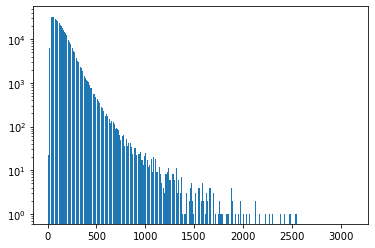

In [199]:
plot_length_bins(stats['quotation']['chars']['length_bins'])

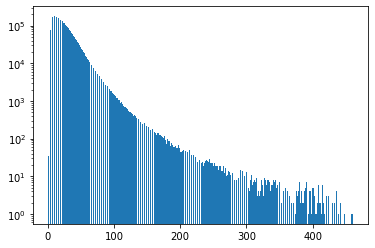

In [198]:
plot_length_bins(stats['quotation']['words']['length_bins'])